# Keras 高层接口
Keras 是一个主要由Python 语言开发的开源神经网络计算库，在TensorFlow 2 版本中，Keras被正式确定为TensorFlow 的高层唯一接口API.在TensorFlow 中，Keras 被实现在tf.keras 子模块中.

Keras 与tf.keras的区别与联系:
- Keras :安装标准的Keras 库就可以方便地调用TensorFlow、CNTK 等后端完成加速计算.
- tf.keras:它与TensorFlow 深度融合，且只能基于TensorFlow 后端运算，并对TensorFlow的支持更完美

## tf.keras 常见功能模块
### 常见网络层类
对于常见的神经网络层，可以使用张量方式的底层接口函数来实现，这些接口函数一般在`tf.nn `模块中.

更常用地，对于常见的网络层，我们一般直接使用层方式来完成模型的搭建，`tf.keras.layers`命名空间下提供了大量常见网络层的类全连接层、激活函数层、池化层、卷积层、循环神经网络层等. 对于这些网络层类，只需要在创建时指定网络层的相关参数，并调用`__call__`方法即可完成前向计算。在调用\__call__方法时，Keras 会自动调用每个层的前向传播逻辑，这些逻辑一般实现在类的call 函数中

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

gpus = tf.config.experimental.list_physical_devices('GPU')
try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

In [2]:
# 例如创建softmax层
x = tf.constant([0.1, 0.5, 2, 1])
layer = layers.Softmax(axis=-1)
out = layer(x)  # 调用softmax前向计算
out

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.08593042, 0.12819313, 0.5745217 , 0.21135475], dtype=float32)>

In [3]:
out = tf.nn.softmax(x)  # 使用函数形式
out

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.08593042, 0.12819313, 0.5745217 , 0.21135475], dtype=float32)>

### 网络容器Sequential
当网络层数变得较深时，可以通过Keras 提供的网络容器Sequential 将多个网络层封装成一个大网络模型，只需要调用网络模型的实例一次即可完成数据从第一层到最末层的顺序传播运算.

In [12]:
from tensorflow.keras import layers, Sequential

network = Sequential([  # 封装为网络
    layers.Dense(3, activation=None),  # 全连接层, 不使用激活函数
    layers.ReLU(),  # 激活函数层
    layers.Dense(2, activation=None),
    layers.ReLU(),
])

In [3]:
x = tf.random.normal([4, 3])
network(x)

<tf.Tensor: id=60, shape=(4, 2), dtype=float32, numpy=
array([[0.0990421 , 0.03670365],
       [0.        , 0.0832989 ],
       [0.08775221, 0.03389173],
       [0.5199914 , 0.26148546]], dtype=float32)>

In [4]:
# add() 方法动态创建网络层
network = Sequential([])
layers_num = 2 # 堆叠2 次
for _ in range(layers_num):
    network.add(layers.Dense(3))
    network.add(layers.ReLU())
network.build(input_shape=(1, 4))  # 创建网络参数 第一个batch_size任意数
network.summary()
# Trainable params 待优化的参数

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              multiple                  15        
_________________________________________________________________
re_lu_2 (ReLU)               multiple                  0         
_________________________________________________________________
dense_3 (Dense)              multiple                  12        
_________________________________________________________________
re_lu_3 (ReLU)               multiple                  0         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________


In [5]:
for params in network.trainable_variables:
    print(params.name, params.shape)  # 参数名 , shape

dense_2/kernel:0 (4, 3)
dense_2/bias:0 (3,)
dense_3/kernel:0 (3, 3)
dense_3/bias:0 (3,)


## 模型装配、训练与测试
在训练网络时，一般的流程是通过前向计算获得网络的输出值，再通过损失函数计算网络误差，然后通过自动求导工具计算梯度并更新，同时间隔性地测试网络的性能。对于这种常用的训练逻辑，可以直接通过Keras 提供的模型装配与训练等高层接口实现，简洁清晰.

In [10]:
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

digits = load_digits()
# data = scale(digits.data)

In [11]:
digits.images[0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

In [4]:
def process(X, y):
    X = tf.cast(X, dtype=tf.float32) / 255.
    X = tf.reshape(X, (-1, 28*28))
    y = tf.cast(y, dtype=tf.int32)
    y_onehot = tf.one_hot(y, depth=10)
    return X, y_onehot

In [9]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.imshow(digits.images[0].reshape(8, 8)/255., cmap=plt.cm.bone)

NameError: name 'digits' is not defined

In [5]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
# X_train, X_test, y_train, y_test = train_test_split(data, digits.target, test_size=0.3, random_state=42)
train_db = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_db = tf.data.Dataset.from_tensor_slices((X_test, y_test))
train_db = train_db.shuffle(10000).batch(512).map(process)
test_db = test_db.shuffle(10000).batch(512).map(process)

In [6]:
X_train.shape

(60000, 28, 28)

In [7]:
x1, y1 = next(iter(train_db))
x1.shape, y1.shape

(TensorShape([512, 784]), TensorShape([512, 10]))

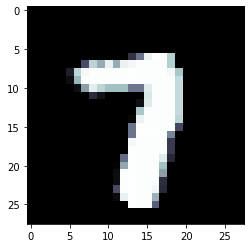

In [10]:
plt.imshow(x1[0].numpy().reshape(28, 28), cmap=plt.cm.bone)

### 模型装配
`keras.layers.Layer` 类是网络层的母类, 定义了网络层的一些常见功能，如添加权值、管理权值列表等.

`keras.Model`类是网络的母类, 除了具有Layer 类的功能，还添加了保存模型、加载模型、训练与测试模型等便捷功能。Sequential 也是Model 的子类，因此具有Model 类的所有功能。

In [13]:
# 手写数字识别MNIST
# 创建5层网络
network = Sequential([
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu',),
    layers.Dense(32, activation='relu'),
    layers.Dense(10),
])
network.build(input_shape=(None, 28*28))
network.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              multiple                  200960    
_________________________________________________________________
dense_3 (Dense)              multiple                  32896     
_________________________________________________________________
dense_4 (Dense)              multiple                  8256      
_________________________________________________________________
dense_5 (Dense)              multiple                  2080      
_________________________________________________________________
dense_6 (Dense)              multiple                  330       
Total params: 244,522
Trainable params: 244,522
Non-trainable params: 0
_________________________________________________________________


建立网络后的训练流程:

- 迭代数据集多次 
- 每次按批产生训练数据、前向计算
- 通过损失函数计算误差值
- 反向传播自动计算梯度、更新网络参数

在Keras 中提供了compile()和fit()函数方便实现上述逻辑

In [14]:
from tensorflow.keras import optimizers, losses

network.compile(optimizer=optimizers.Adam(lr=0.01),  # Adam优化器, 学习率0.01
               loss=losses.CategoricalCrossentropy(from_logits=True),  # 交叉熵损失,包含softmax
               metrics=['accuracy'],   # 指标为准确率
               )

### 模型训练
模型装配完成后，即可通过fit()函数送入待训练的数据集和验证用的数据集，这一步称为模型训练。

In [15]:
history = network.fit(train_db, epochs=20,
                      validation_data=test_db,
                      validation_freq=2)  # 每2个epoch验证一次

Train for 118 steps, validate for 20 steps
Epoch 1/20
118/118 [==============================] - 1s 12ms/step - loss: 0.3646 - accuracy: 0.8857
Epoch 2/20
118/118 [==============================] - 1s 8ms/step - loss: 0.1141 - accuracy: 0.9661 - val_loss: 0.1347 - val_accuracy: 0.9607
Epoch 3/20
118/118 [==============================] - 1s 5ms/step - loss: 0.0879 - accuracy: 0.9735
Epoch 4/20
118/118 [==============================] - 1s 6ms/step - loss: 0.0675 - accuracy: 0.9800 - val_loss: 0.1124 - val_accuracy: 0.9695
Epoch 5/20
118/118 [==============================] - 1s 6ms/step - loss: 0.0577 - accuracy: 0.9825
Epoch 6/20
118/118 [==============================] - 1s 7ms/step - loss: 0.0472 - accuracy: 0.9853 - val_loss: 0.0953 - val_accuracy: 0.9749
Epoch 7/20
118/118 [==============================] - 1s 6ms/step - loss: 0.0413 - accuracy: 0.9869
Epoch 8/20
118/118 [==============================] - 1s 7ms/step - loss: 0.0420 - accuracy: 0.9865 - val_loss: 0.0980 - val_accur

In [16]:
history.history

{'loss': [0.3653977931022644,
  0.11424525569677353,
  0.08810408254663149,
  0.06744905774195989,
  0.0577793673992157,
  0.04747855045447747,
  0.041166434274117154,
  0.04217935461997986,
  0.03653405509144068,
  0.03381032163351774,
  0.03632593816518784,
  0.03303831809113423,
  0.024563255556424458,
  0.02585742873350779,
  0.021704516445597014,
  0.021665821890036265,
  0.02431395639181137,
  0.024409881953398386,
  0.021804736897349356,
  0.01833806438750277],
 'accuracy': [0.88566667,
  0.96608335,
  0.97345,
  0.98,
  0.98245,
  0.9853333,
  0.98686665,
  0.98651665,
  0.98865,
  0.98948336,
  0.98905,
  0.9902667,
  0.99216664,
  0.9924,
  0.99326664,
  0.9938167,
  0.9927,
  0.99305,
  0.9937,
  0.99481666],
 'val_loss': [0.134742646291852,
  0.1124394565820694,
  0.09529248671606183,
  0.09803355894982815,
  0.10618601720780134,
  0.11213826444000005,
  0.12743312437087298,
  0.10804300159215927,
  0.13276409804821016,
  0.11128770057111978],
 'val_accuracy': [0.9607,
  0.

### 模型测试
Model 基类除了可以便捷地完成网络的装配与训练、验证，还可以非常方便的预测和测试.

In [17]:
x, y = next(iter(test_db))  # 加载一个batch数据

In [18]:
y.shape

TensorShape([512, 10])

In [19]:
out = network.predict(x)  # 模型预测，预测结果保存在out 中
y_pred = np.argmax(out, axis=-1)  

In [20]:
out.shape

(512, 10)

In [21]:
y_t = np.argmax(y, axis=-1)

In [22]:
np.sum(y_t.ravel() == y_pred.ravel()) / len(y_pred)

0.98046875

In [23]:
network.evaluate(test_db)  # test_db上的性能测试

20/20 [==============================] - 0s 5ms/step - loss: 0.1092 - accuracy: 0.9760


[0.1091868069022894, 0.976]

## 模型的保存和加载
### 张量方式

In [208]:
network.save_weights('mnist_weights.ckpt')

In [209]:
del network

In [210]:
network = Sequential([
#     layers.Dense(256, activation='relu'),
#     layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu', dtype='float64'),
    layers.Dense(32, activation='relu', dtype='float64'),
    layers.Dense(10, dtype='float64'),
])
network.compile(optimizer=optimizers.Adam(lr=0.01),
               loss=losses.CategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

In [211]:
network.load_weights('mnist_weights.ckpt')

In [212]:
network.build(input_shape=(4, 8*8))
network.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_73 (Dense)             multiple                  4160      
_________________________________________________________________
dense_74 (Dense)             multiple                  2080      
_________________________________________________________________
dense_75 (Dense)             multiple                  330       
Total params: 6,570
Trainable params: 6,570
Non-trainable params: 0
_________________________________________________________________


这种保存与加载网络的方式最为轻量级，文件中保存的仅仅是张量参数的数值，并没有其
它额外的结构参数。但是它需要使用相同的网络结构才能够正确恢复网络状态，因此一般
在拥有网络源文件的情况下使用

### 网络方式

model.h5 文件除了保存了模型参数外，还应保存了网络结构信息，不需要提前
创建模型即可直接从文件中恢复出网络network 对象

In [213]:
network.save('model.h5')
del network

In [225]:
network = keras.models.load_model('model.h5')
network.build(input_shape=(4, 8*8))
network.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_73 (Dense)             multiple                  4160      
_________________________________________________________________
dense_74 (Dense)             multiple                  2080      
_________________________________________________________________
dense_75 (Dense)             multiple                  330       
Total params: 6,570
Trainable params: 6,570
Non-trainable params: 0
_________________________________________________________________


### SavedModel
SavedModel 方式具有平台无关性

In [233]:
tf.saved_model.save(network, 'model-savedmodel')

INFO:tensorflow:Assets written to: model-savedmodel\assets


In [234]:
network = tf.saved_model.load('model-savedmodel')
network

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x22940ef0>

In [228]:
tf.saved_model.load?

In [235]:
acc_meter = keras.metrics.CategoricalAccuracy()
for x, y in test_db:
    pred = network(x)
    acc_meter.update_state(y_true=y, y_pred=pred)
print("Test Accuracy:%f" % acc_meter.result())

Test Accuracy:0.881481


## 自定义网络
### 自定义网络层

至少需要实现初始化\__init__方法和前向传播逻辑call 方法

In [242]:
layers.Layer.add_weight

<function tensorflow.python.keras.engine.base_layer.Layer.add_weight(self, name=None, shape=None, dtype=None, initializer=None, regularizer=None, trainable=None, constraint=None, partitioner=None, use_resource=None, synchronization=<VariableSynchronization.AUTO: 0>, aggregation=<VariableAggregation.NONE: 0>, **kwargs)>

In [256]:
layers.Layer?

In [24]:
class MyDense(layers.Layer):
    def __init__(self, input_dim, out_dim):
        super().__init__()
        # 创建权值张量并添加到类管理列表中，设置为需要优化
        self.kernel = self.add_weight(shape=(input_dim, out_dim), trainable=True)
        # 没有偏置
    def call(self, inputs, training=None):
        # 实现前向计算
        out = inputs @ self.kernel
        out = tf.nn.relu(out)
        return out

In [268]:
net = MyDense(4, 3)
net.weights, net.trainable_variables
# 类初始化中创建为tf.Variable类型的类成员变量也会自动纳入张量管理中

([<tf.Variable 'Variable:0' shape=(4, 3) dtype=float32, numpy=
  array([[ 0.60043955,  0.63166153, -0.6026592 ],
         [-0.87410927,  0.70786154,  0.7381562 ],
         [-0.42485708, -0.26497793,  0.64553   ],
         [-0.10666221,  0.92383635,  0.90859616]], dtype=float32)>],
 [<tf.Variable 'Variable:0' shape=(4, 3) dtype=float32, numpy=
  array([[ 0.60043955,  0.63166153, -0.6026592 ],
         [-0.87410927,  0.70786154,  0.7381562 ],
         [-0.42485708, -0.26497793,  0.64553   ],
         [-0.10666221,  0.92383635,  0.90859616]], dtype=float32)>])

In [266]:
net.variables

[<tf.Variable 'Variable:0' shape=(4, 3) dtype=float32, numpy=
 array([[ 0.754328  , -0.9152435 ,  0.13642979],
        [-0.32667977,  0.41843903, -0.90037096],
        [-0.51423925,  0.3639443 ,  0.49711728],
        [ 0.84835196,  0.8868474 ,  0.6283009 ]], dtype=float32)>]

In [274]:
x = tf.random.normal([3, 4])
x

<tf.Tensor: id=57468, shape=(3, 4), dtype=float32, numpy=
array([[ 0.3998409 , -0.97267   ,  0.6637845 , -1.2764329 ],
       [ 1.1170532 ,  0.73980343, -0.47469783,  0.729653  ],
       [ 0.61917156, -0.7106153 ,  0.11225893, -0.31066328]],
      dtype=float32)>

In [276]:
net(x)

<tf.Tensor: id=57471, shape=(3, 3), dtype=float32, numpy=
array([[0.9444338 , 0.        , 0.        ],
       [0.14790618, 2.0291421 , 0.22941633],
       [0.97837245, 0.        , 0.        ]], dtype=float32)>

### 自定义网络

Sequential 容器适合于数据按序从第一层传播到第二层，再从第二层传播到第三层，以此规律传播的网络模型.

对于复杂的网络结构, 使用自定义网络类更加灵活

In [278]:
network = Sequential([
    MyDense(784, 256), 
    MyDense(256, 128), 
    MyDense(128, 64), 
    MyDense(64, 32), 
    MyDense(32, 10), 
])
network.build(input_shape=(None, 8*8))
network.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_dense_9 (MyDense)         multiple                  2048      
_________________________________________________________________
my_dense_10 (MyDense)        multiple                  320       
Total params: 2,368
Trainable params: 2,368
Non-trainable params: 0
_________________________________________________________________


In [25]:
class MyModel(keras.Model):# 自定义网络类，继承自 Model 基类
    def __init__(self):
        super().__init__()
        self.fc1 = MyDense(28*28, 256)
        self.fc2 = MyDense(256, 128)
        self.fc3 = MyDense(128, 64)
        self.fc4 = MyDense(64, 32)
        self.fc5 = MyDense(32, 10)
    def call(self, inputs, training=None):
        # 自定义前向运算逻辑
        x = self.fc1(inputs)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        return x

In [26]:
model = MyModel()
model.build(input_shape=(None, 28*28))
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_dense (MyDense)           multiple                  200704    
_________________________________________________________________
my_dense_1 (MyDense)         multiple                  32768     
_________________________________________________________________
my_dense_2 (MyDense)         multiple                  8192      
_________________________________________________________________
my_dense_3 (MyDense)         multiple                  2048      
_________________________________________________________________
my_dense_4 (MyDense)         multiple                  320       
Total params: 244,032
Trainable params: 244,032
Non-trainable params: 0
_________________________________________________________________


In [29]:
resnet = keras.applications.ResNet50(weights='imagenet', include_top=False)

KeyboardInterrupt: 